In [1]:
import warnings
import pandas as pd
import utils
import plotly.express as px
import numpy as np

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Calculating mean Average Precision (mAP) for CellProfiler features
In this notebook, we calculate the mAP for perturbation detection and perturbation matching tasks for the CellProfiler features.

All compound, ORF and CRISPR plates from the `2020_11_04_CPJUMP1` batch are read, except for those with cell seeding density other than 1000 (100%) and compound plates with antibiotics (Puromycin/Blasticidin) added. Additional annotations for the compounds are also read.

In [2]:
replicability_map_df = pd.DataFrame()
replicability_fr_df = pd.DataFrame()
matching_map_df = pd.DataFrame()
matching_fr_df = pd.DataFrame()
gene_compound_matching_map_df = pd.DataFrame()
gene_compound_matching_fr_df = pd.DataFrame()

replicate_feature = "Metadata_broad_sample"
batch = "2020_11_04_CPJUMP1"
batch_size = 100000
null_size = 100000

experiment_df = (
    pd.read_csv("output/experiment-metadata.tsv", sep="\t")
    .query("Batch==@batch")
    .query("Density==100")
    .query('Antibiotics=="absent"')
)

experiment_df.drop(
    experiment_df[
        (experiment_df.Perturbation == "compound") & (experiment_df.Cell_line == "Cas9")
    ].index,
    inplace=True,
)

target1_metadata = pd.read_csv(
    "input/JUMP-Target-1_compound_metadata_additional_annotations.tsv",
    sep="\t",
    usecols=["broad_sample", "target_list"],
).rename(
    columns={
        "broad_sample": "Metadata_broad_sample",
        "target_list": "Metadata_target_list",
    }
)

Normalized, feature selected compound profiles for replicate plates at the same time point, using the same cell type are merged into a single data frame. Empty wells are removed before calculating mAP for perturbation detection (retrieve replicates of the query compound). mAP for the random baseline (10000 random list of size number of replicates + number of negcon) is subtracted.

For the perturbation matching task, compounds that not are replicable (qvalue > 0.05) are removed. Negative control wells are also removed and the additional target annotations are added before mAP for perturbation matching is calculated. Again, the mAP for the random baseline is subtracted.

Similarly, mAP for perturbation detection is computed for both CRISPR and ORF plates while mAP for perturbation matching is computed only for the CRISPR guides as there are no sister ORF perturbations.

Then, mAP for the chemical perturbation-genetic perturbation matching task is computed using the median consensus profiles and the baseline mAP is subtracted.

Along with mAP, fraction retrieved is also calculated. This is the fraction of queries that have qvalue < 0.05.

The mAP and fraction retrieved values as saved to `output` directory and the results are plotted.

In [3]:
for cell in experiment_df.Cell_type.unique():
    cell_df = experiment_df.query("Cell_type==@cell")
    modality_1_perturbation = "compound"
    modality_1_experiments_df = cell_df.query("Perturbation==@modality_1_perturbation")
    for modality_1_timepoint in modality_1_experiments_df.Time.unique():
        modality_1_timepoint_df = modality_1_experiments_df.query(
            "Time==@modality_1_timepoint"
        )
        modality_1_df = pd.DataFrame()
        for plate in modality_1_timepoint_df.Assay_Plate_Barcode.unique():
            # Read all the plates
            data_df = utils.load_data(
                batch, plate, "normalized_feature_select_negcon_batch.csv.gz"
            ).assign(Metadata_modality=modality_1_perturbation)
            modality_1_df = utils.concat_profiles(modality_1_df, data_df)

        # Set Metadata_broad_sample value to "DMSO" for DMSO wells
        modality_1_df[replicate_feature].fillna("DMSO", inplace=True)

        # Remove empty wells
        modality_1_df = utils.remove_empty_wells(modality_1_df)

        # Description
        description = f"{modality_1_perturbation}_{cell}_{utils.time_point(modality_1_perturbation, modality_1_timepoint)}"

        # Calculate replicability mAP
        print(f"Computing {description} replicability")

        modality_1_df["Metadata_negcon"] = np.where(
            modality_1_df["Metadata_control_type"] == "negcon", 1, 0
        )  # Create dummy column

        pos_sameby = ["Metadata_broad_sample"]
        pos_diffby = []
        neg_sameby = ["Metadata_Plate"]
        neg_diffby = ["Metadata_negcon"]

        metadata_df = utils.get_metadata(modality_1_df)
        feature_df = utils.get_featuredata(modality_1_df)
        feature_values = feature_df.values

        result = utils.run_pipeline(
            metadata_df,
            feature_values,
            pos_sameby,
            pos_diffby,
            neg_sameby,
            neg_diffby,
            anti_match=False,
            batch_size=batch_size,
            null_size=null_size,
        )

        result = result.query("Metadata_negcon==0").reset_index(drop=True)

        replicability_map_df, replicability_fr_df = utils.create_replicability_df(
            replicability_map_df,
            replicability_fr_df,
            result,
            pos_sameby,
            0.05,
            modality_1_perturbation,
            cell,
            modality_1_timepoint,
        )

        # Remove DMSO wells
        modality_1_df = utils.remove_negcon_and_empty_wells(modality_1_df)

        # Create consensus profiles
        modality_1_consensus_df = utils.consensus(modality_1_df, replicate_feature)

        # Filter out non-replicable compounds
        replicable_compounds = list(
            replicability_map_df[
                (replicability_map_df.Description == description)
                & (replicability_map_df.above_q_threshold == True)
            ][replicate_feature]
        )
        modality_1_consensus_df = modality_1_consensus_df.query(
            "Metadata_broad_sample==@replicable_compounds"
        ).reset_index(drop=True)

        # Adding additional gene annotation metadata
        modality_1_consensus_df = (
            modality_1_consensus_df.merge(
                target1_metadata, on="Metadata_broad_sample", how="left"
            )
            .assign(
                Metadata_matching_target=lambda x: x.Metadata_target_list.str.split("|")
            )
            .drop(["Metadata_target_list"], axis=1)
        )

        # Calculate compound-compound matching
        print(f"Computing {description} matching")

        pos_sameby = ["Metadata_matching_target"]
        pos_diffby = []
        neg_sameby = []
        neg_diffby = ["Metadata_matching_target"]

        metadata_df = utils.get_metadata(modality_1_consensus_df)
        feature_df = utils.get_featuredata(modality_1_consensus_df)
        feature_values = feature_df.values

        result = utils.run_pipeline(
            metadata_df,
            feature_values,
            pos_sameby,
            pos_diffby,
            neg_sameby,
            neg_diffby,
            anti_match=True,
            batch_size=batch_size,
            null_size=null_size,
            multilabel_col="Metadata_matching_target",
        )

        matching_map_df, matching_fr_df = utils.create_matching_df(
            matching_map_df,
            matching_fr_df,
            result,
            pos_sameby,
            0.05,
            modality_1_perturbation,
            cell,
            modality_1_timepoint,
        )

        all_modality_2_experiments_df = cell_df.query(
            "Perturbation!=@modality_1_perturbation"
        )
        for (
            modality_2_perturbation
        ) in all_modality_2_experiments_df.Perturbation.unique():
            modality_2_experiments_df = all_modality_2_experiments_df.query(
                "Perturbation==@modality_2_perturbation"
            )
            for modality_2_timepoint in modality_2_experiments_df.Time.unique():
                modality_2_timepoint_df = modality_2_experiments_df.query(
                    "Time==@modality_2_timepoint"
                )

                modality_2_df = pd.DataFrame()
                for plate in modality_2_timepoint_df.Assay_Plate_Barcode.unique():
                    data_df = (
                        utils.load_data(
                            batch,
                            plate,
                            "normalized_feature_select_negcon_batch.csv.gz",
                        )
                        .assign(Metadata_modality=modality_2_perturbation)
                        .assign(Metadata_matching_target=lambda x: x.Metadata_gene)
                    )
                    modality_2_df = utils.concat_profiles(modality_2_df, data_df)

                # Remove empty wells
                modality_2_df = utils.remove_empty_wells(modality_2_df)

                # Description
                description = f"{modality_2_perturbation}_{cell}_{utils.time_point(modality_2_perturbation, modality_2_timepoint)}"

                # Calculate replicability mAP

                if not replicability_map_df.Description.str.contains(description).any():
                    print(f"Computing {description} replicability")

                    modality_2_df["Metadata_negcon"] = np.where(
                        modality_2_df["Metadata_control_type"] == "negcon", 1, 0
                    )  # Create dummy column

                    pos_sameby = ["Metadata_broad_sample"]
                    pos_diffby = []
                    neg_sameby = ["Metadata_Plate"]
                    neg_diffby = ["Metadata_negcon"]

                    metadata_df = utils.get_metadata(modality_2_df)
                    feature_df = utils.get_featuredata(modality_2_df)
                    feature_values = feature_df.values

                    result = utils.run_pipeline(
                        metadata_df,
                        feature_values,
                        pos_sameby,
                        pos_diffby,
                        neg_sameby,
                        neg_diffby,
                        anti_match=False,
                        batch_size=batch_size,
                        null_size=null_size,
                    )

                    result = result.query("Metadata_negcon==0").reset_index(drop=True)

                    (
                        replicability_map_df,
                        replicability_fr_df,
                    ) = utils.create_replicability_df(
                        replicability_map_df,
                        replicability_fr_df,
                        result,
                        pos_sameby,
                        0.05,
                        modality_2_perturbation,
                        cell,
                        modality_2_timepoint,
                    )

                # Remove negcon wells
                modality_2_df = utils.remove_negcon_and_empty_wells(modality_2_df)

                # Create consensus profiles
                modality_2_consensus_df = utils.consensus(
                    modality_2_df, "Metadata_broad_sample"
                )

                # Filter out non-replicable genes
                replicable_genes = list(
                    replicability_map_df[
                        (
                            replicability_map_df.Description
                            == f"{modality_2_perturbation}_{cell}_{utils.time_point(modality_2_perturbation, modality_2_timepoint)}"
                        )
                        & (replicability_map_df.above_q_threshold == True)
                    ][replicate_feature]
                )
                modality_2_consensus_df = modality_2_consensus_df.query(
                    "Metadata_broad_sample==@replicable_genes"
                ).reset_index(drop=True)

                # Filter out reagents without a sister guide

                genes_without_sister = (
                    modality_2_consensus_df.Metadata_gene.value_counts()
                    .reset_index()
                    .query("Metadata_gene==1")["index"]
                    .to_list()
                )

                modality_2_consensus_for_matching_df = (
                    modality_2_consensus_df.query(
                        "Metadata_gene!=@genes_without_sister"
                    ).reset_index(drop=True)
                )

                # Calculate cripsr-crispr matching
                if modality_2_perturbation == "crispr":
                    if not matching_map_df.Description.str.contains(description).any():
                        print(f"Computing {description} matching")

                        pos_sameby = ["Metadata_gene"]
                        pos_diffby = []
                        neg_sameby = []
                        neg_diffby = ["Metadata_gene"]

                        metadata_df = utils.get_metadata(modality_2_consensus_for_matching_df)
                        feature_df = utils.get_featuredata(modality_2_consensus_for_matching_df)
                        feature_values = feature_df.values

                        result = utils.run_pipeline(
                            metadata_df,
                            feature_values,
                            pos_sameby,
                            pos_diffby,
                            neg_sameby,
                            neg_diffby,
                            anti_match=False,
                            batch_size=batch_size,
                            null_size=null_size,
                        )

                        matching_map_df, matching_fr_df = utils.create_matching_df(
                            matching_map_df,
                            matching_fr_df,
                            result,
                            pos_sameby,
                            0.05,
                            modality_2_perturbation,
                            cell,
                            modality_2_timepoint,
                        )

                # Filter out genes that are not perturbed by ORFs or CRISPRs
                perturbed_genes = list(
                    set(modality_2_consensus_df.Metadata_matching_target)
                )

                modality_1_filtered_genes_df = (
                    modality_1_consensus_df[
                        ["Metadata_broad_sample", "Metadata_matching_target"]
                    ]
                    .copy()
                    .explode("Metadata_matching_target")
                    .query("Metadata_matching_target==@perturbed_genes")
                    .reset_index(drop=True)
                    .groupby(["Metadata_broad_sample"])
                    .Metadata_matching_target.apply(list)
                    .reset_index()
                )

                modality_1_consensus_filtered_df = modality_1_consensus_df.drop(
                    columns=["Metadata_matching_target"]
                ).merge(
                    modality_1_filtered_genes_df,
                    on="Metadata_broad_sample",
                    how="inner",
                )

                # Calculate gene-compound matching mAP
                description = f"{modality_1_perturbation}_{cell}_{utils.time_point(modality_1_perturbation, modality_1_timepoint)}-{modality_2_perturbation}_{cell}_{utils.time_point(modality_2_perturbation, modality_2_timepoint)}"
                print(f"Computing {description} matching")

                modality_1_modality_2_df = utils.concat_profiles(
                    modality_1_consensus_filtered_df, modality_2_consensus_df
                )

                pos_sameby = ["Metadata_matching_target"]
                pos_diffby = ["Metadata_modality"]
                neg_sameby = []
                neg_diffby = ["Metadata_matching_target", "Metadata_modality"]

                metadata_df = utils.get_metadata(modality_1_modality_2_df)
                feature_df = utils.get_featuredata(modality_1_modality_2_df)
                feature_values = feature_df.values

                result = utils.run_pipeline(
                    metadata_df,
                    feature_values,
                    pos_sameby,
                    pos_diffby,
                    neg_sameby,
                    neg_diffby,
                    anti_match=True,
                    batch_size=batch_size,
                    null_size=null_size,
                    multilabel_col="Metadata_matching_target",
                )

                (
                    gene_compound_matching_map_df,
                    gene_compound_matching_fr_df,
                ) = utils.create_gene_compound_matching_df(
                    gene_compound_matching_map_df,
                    gene_compound_matching_fr_df,
                    result,
                    pos_sameby,
                    0.05,
                    modality_1_perturbation,
                    modality_2_perturbation,
                    cell,
                    modality_1_timepoint,
                    modality_2_timepoint,
                )

Computing compound_A549_short replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_A549_short matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing crispr_A549_long replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing crispr_A549_long matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_A549_short-crispr_A549_long matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing crispr_A549_short replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing crispr_A549_short matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_A549_short-crispr_A549_short matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing orf_A549_long replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_A549_short-orf_A549_long matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing orf_A549_short replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_A549_short-orf_A549_short matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_A549_long replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_A549_long matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_A549_long-crispr_A549_long matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_A549_long-crispr_A549_short matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_A549_long-orf_A549_long matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_A549_long-orf_A549_short matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_U2OS_short replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_U2OS_short matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing crispr_U2OS_long replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing crispr_U2OS_long matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_U2OS_short-crispr_U2OS_long matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing crispr_U2OS_short replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing crispr_U2OS_short matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_U2OS_short-crispr_U2OS_short matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing orf_U2OS_short replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_U2OS_short-orf_U2OS_short matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing orf_U2OS_long replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_U2OS_short-orf_U2OS_long matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_U2OS_long replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_U2OS_long matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_U2OS_long-crispr_U2OS_long matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_U2OS_long-crispr_U2OS_short matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_U2OS_long-orf_U2OS_short matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing compound_U2OS_long-orf_U2OS_long matching


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Tables of mAP values and the fraction retrieved (fr) are printed and bar plots are plotted.

Replicability fraction retrieved.

In [4]:
print(replicability_fr_df[["Description", "timepoint", "fr"]].to_markdown(index=False))

| Description         |   timepoint |    fr |
|:--------------------|------------:|------:|
| compound_A549_short |          24 | 0.761 |
| crispr_A549_long    |         144 | 0.679 |
| crispr_A549_short   |          96 | 0.682 |
| orf_A549_long       |          96 | 0.05  |
| orf_A549_short      |          48 | 0.05  |
| compound_A549_long  |          48 | 0.954 |
| compound_U2OS_short |          24 | 0.775 |
| crispr_U2OS_long    |         144 | 0.482 |
| crispr_U2OS_short   |          96 | 0.669 |
| orf_U2OS_short      |          48 | 0.369 |
| orf_U2OS_long       |          96 | 0.2   |
| compound_U2OS_long  |          48 | 0.663 |


Within perturbation matching fractive retrieved.

In [5]:
print(matching_fr_df[["Description", "timepoint", "fr"]].to_markdown(index=False))

| Description         |   timepoint |    fr |
|:--------------------|------------:|------:|
| compound_A549_short |          24 | 0.133 |
| crispr_A549_long    |         144 | 0.123 |
| crispr_A549_short   |          96 | 0.11  |
| compound_A549_long  |          48 | 0.169 |
| compound_U2OS_short |          24 | 0.043 |
| crispr_U2OS_long    |         144 | 0.167 |
| crispr_U2OS_short   |          96 | 0.068 |
| compound_U2OS_long  |          48 | 0.246 |


Gene-compound matching fraction retrieved.

In [6]:
print(
    gene_compound_matching_fr_df[["Description", "Cell", "fr"]].to_markdown(index=False)
)

| Description                           | Cell   |    fr |
|:--------------------------------------|:-------|------:|
| compound_A549_short-crispr_A549_long  | A549   | 0.008 |
| compound_A549_short-crispr_A549_short | A549   | 0.008 |
| compound_A549_short-orf_A549_long     | A549   | 0     |
| compound_A549_short-orf_A549_short    | A549   | 0     |
| compound_A549_long-crispr_A549_long   | A549   | 0.007 |
| compound_A549_long-crispr_A549_short  | A549   | 0.007 |
| compound_A549_long-orf_A549_long      | A549   | 0     |
| compound_A549_long-orf_A549_short     | A549   | 0     |
| compound_U2OS_short-crispr_U2OS_long  | U2OS   | 0     |
| compound_U2OS_short-crispr_U2OS_short | U2OS   | 0.016 |
| compound_U2OS_short-orf_U2OS_short    | U2OS   | 0     |
| compound_U2OS_short-orf_U2OS_long     | U2OS   | 0     |
| compound_U2OS_long-crispr_U2OS_long   | U2OS   | 0.033 |
| compound_U2OS_long-crispr_U2OS_short  | U2OS   | 0.009 |
| compound_U2OS_long-orf_U2OS_short     | U2OS   | 0.075

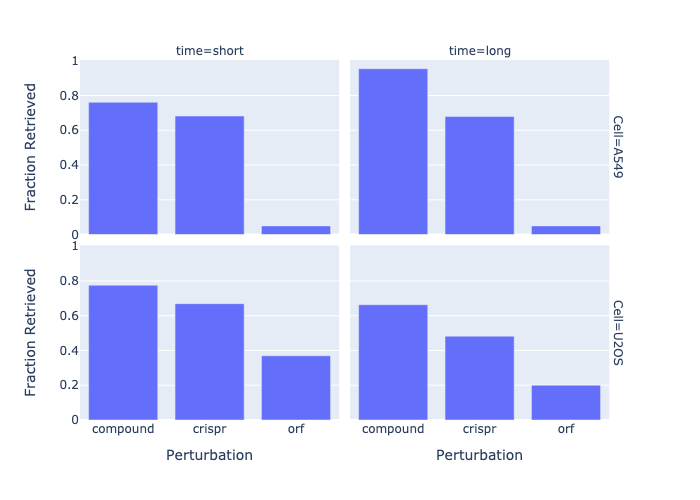

In [7]:
fig = px.bar(
    data_frame=replicability_fr_df,
    x="Modality",
    y="fr",
    facet_row="Cell",
    facet_col="time",
)
fig.update_layout(
    xaxis1=dict(title="Perturbation"),
    xaxis2=dict(title="Perturbation"),
    yaxis1=dict(title="Fraction Retrieved"),
    yaxis3=dict(title="Fraction Retrieved"),
)
fig.show("png")
fig.write_image(
    f"figures/1.CellProfiler_replicability_fr.png", width=640, height=480, scale=2
)

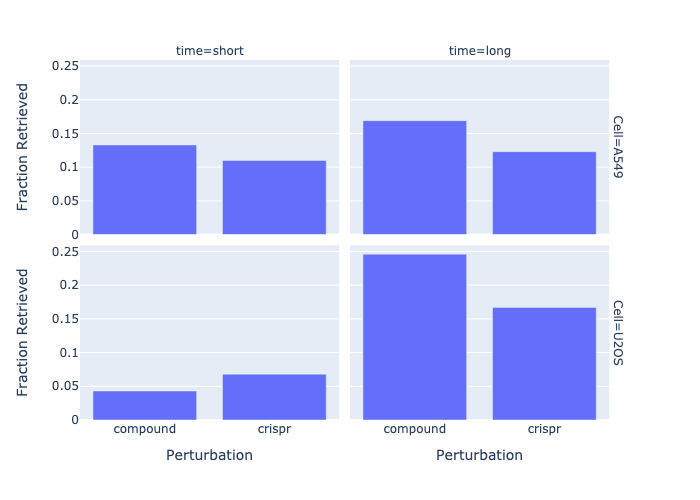

In [8]:
fig = px.bar(
    data_frame=matching_fr_df,
    x="Modality",
    y="fr",
    facet_row="Cell",
    facet_col="time",
)
fig.update_layout(
    xaxis1=dict(title="Perturbation"),
    xaxis2=dict(title="Perturbation"),
    yaxis1=dict(title="Fraction Retrieved"),
    yaxis3=dict(title="Fraction Retrieved"),
)
fig.show("png")
fig.write_image(
    f"figures/1.CellProfiler_matching_fr.png", width=640, height=480, scale=2
)

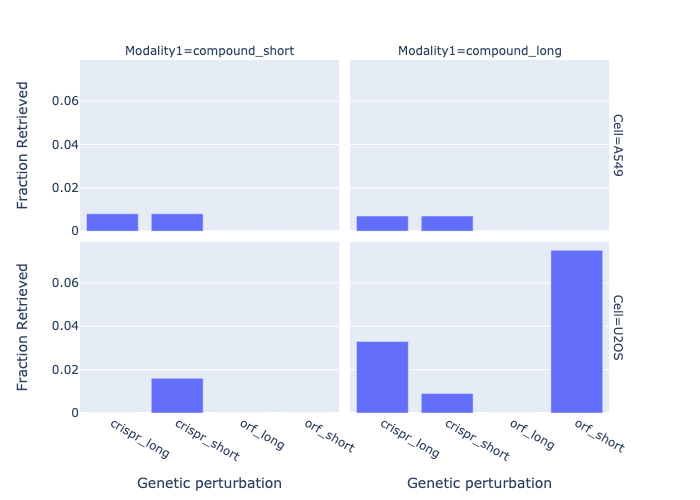

In [9]:
fig = px.bar(
    gene_compound_matching_fr_df,
    x="Modality2",
    y="fr",
    facet_col="Modality1",
    facet_row="Cell",
)
fig.update_layout(
    xaxis1=dict(title="Genetic perturbation"),
    xaxis2=dict(title="Genetic perturbation"),
    yaxis1=dict(title="Fraction Retrieved"),
    yaxis3=dict(title="Fraction Retrieved"),
)
fig.show("png")
fig.write_image(
    f"figures/1.CellProfiler_gene_compound_matching_fr.png",
    width=640,
    height=480,
    scale=2,
)

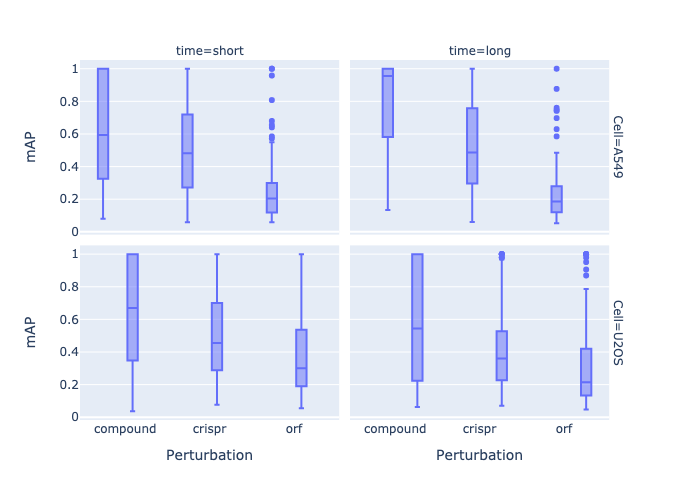

In [10]:
fig = px.box(
    data_frame=replicability_map_df,
    x="Modality",
    y="mean_average_precision",
    facet_row="Cell",
    facet_col="time",
)
fig.update_layout(
    xaxis1=dict(title="Perturbation"),
    xaxis2=dict(title="Perturbation"),
    yaxis1=dict(title="mAP"),
    yaxis3=dict(title="mAP"),
)
fig.show("png")
fig.write_image(
    f"figures/1.CellProfiler_replicability_map.png", width=640, height=480, scale=2
)

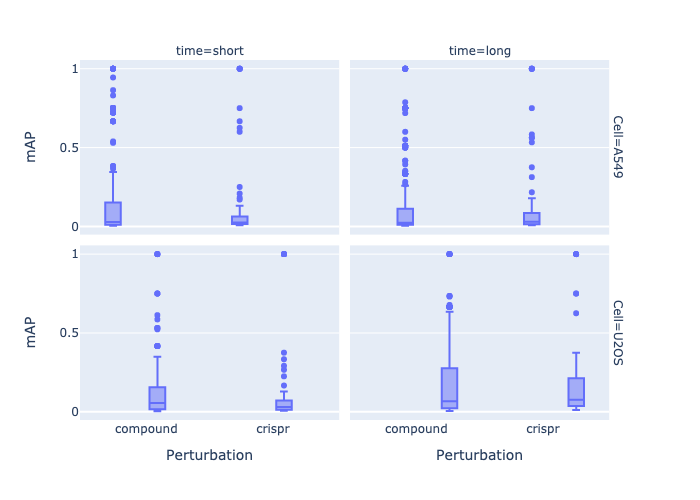

In [11]:
fig = px.box(
    data_frame=matching_map_df,
    x="Modality",
    y="mean_average_precision",
    facet_row="Cell",
    facet_col="time",
)
fig.update_layout(
    xaxis1=dict(title="Perturbation"),
    xaxis2=dict(title="Perturbation"),
    yaxis1=dict(title="mAP"),
    yaxis3=dict(title="mAP"),
)
fig.show("png")
fig.write_image(
    f"figures/1.CellProfiler_matching_map.png", width=640, height=480, scale=2
)

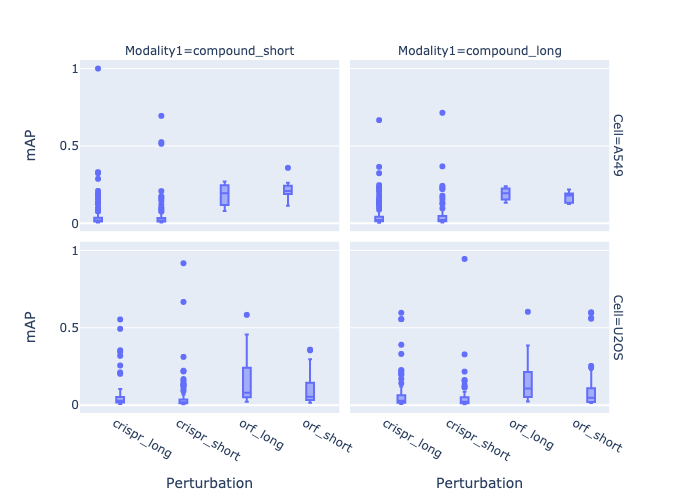

In [12]:
fig = px.box(
    data_frame=gene_compound_matching_map_df,
    x="Modality2",
    y="mean_average_precision",
    facet_col="Modality1",
    facet_row="Cell",
)
fig.update_layout(
    xaxis1=dict(title="Perturbation"),
    xaxis2=dict(title="Perturbation"),
    yaxis1=dict(title="mAP"),
    yaxis3=dict(title="mAP"),
)
fig.show("png")
fig.write_image(
    f"figures/1.CellProfiler_gene_compound_matching_map.png",
    width=640,
    height=480,
    scale=2,
)

Tables of mAP and fr values are written to file.

In [13]:
replicability_fr_df.to_csv("output/cellprofiler_replicability_fr.csv", index=False)
replicability_map_df.to_csv("output/cellprofiler_replicability_map.csv", index=False)
matching_fr_df.to_csv("output/cellprofiler_matching_fr.csv", index=False)
matching_map_df.to_csv("output/cellprofiler_matching_map.csv", index=False)
gene_compound_matching_fr_df.to_csv(
    "output/cellprofiler_gene_compound_matching_fr.csv", index=False
)
gene_compound_matching_map_df.to_csv(
    "output/cellprofiler_gene_compound_matching_map.csv", index=False
)